In [1]:
%pylab inline
import librosa
from IPython.display import Audio
from scipy.io import wavfile
# import peakutils
import pickle
import pandas as pd
import os
import glob
from collections import OrderedDict
import seaborn as sns

from statsmodels.stats.multicomp import pairwise_tukeyhsd

sns.set_style("ticks")

def rc_default():
    mpl.rc('figure',figsize=(10,6));
    mpl.rc('figure',dpi=70);
    mpl.rc('legend',fontsize=16);
    mpl.rc('font',size=32);
    mpl.rc('xtick',labelsize=32);
    mpl.rc('ytick',labelsize=32);
    mpl.rc('axes',labelsize=32);

rc_default()

def mask_outliers(x, outlier_constant=1.5):
    a = np.array(x)
    upper_quartile = np.percentile(a, 75)
    lower_quartile = np.percentile(a, 25)
    IQR = (upper_quartile - lower_quartile) * outlier_constant
    quartileSet = (lower_quartile - IQR, upper_quartile + IQR)

    return (a > quartileSet[0]) & (a < quartileSet[1])

Populating the interactive namespace from numpy and matplotlib


In [2]:
path = 'respuestas/'
df = pd.DataFrame()
for filename in glob.glob(path+'*notas*.pickle'):
    subject = filename.split('_')[2]
    
    df_ = pd.read_pickle(filename)
    
    if subject=='jcq':
        df_.subject=['jcq']*len(df_.subject)
#         print(df_.subject)
    
    df_.subject = [ df_.iloc[0].subject.lower() ]*len(df_.subject)

        
    if 'valid' in df_.columns:
        df_ = df_[df_.valid]
   
    df = pd.concat([df,df_],axis=0)
    
df = df.reset_index()
n_subjects = len(df.subject.unique())

In [3]:
len(glob.glob(path+'*notas*.pickle')), n_subjects,df.subject.unique()

(27, 27, array(['arg', 'agp', 'luc', 'aes', 'smp', 'per', 'psm', 'ntr', 'cab',
        'ans', 'sll', 'ael', 'lga', 'ins', 'fmc', 'jcc', 'asa', 'jcq',
        'esr', 'ess', 'lev', 'ceb', 'mil', 'lib', 'fes', 'aac', 'mgd'], dtype=object))

In [4]:
for i,r in df.iterrows():
    x = (r.t_taps[1:] - r.t_taps[0])/r.fs
    df.set_value(i,'t_taps',x )

## Los outliers se sacan teniendo en cuenta todos los i_taps en cada condición

In [91]:
from scipy.stats import linregress
from IPython import embed

def OUTLIERS_MU_Y_SD(l):
    y = vstack(l.values)
    mask = ones(y.shape[0],dtype=bool)
    for i in range(y.shape[1]):
        mask = (mask) & ( mask_outliers(y[:,i],1.5) )
    n = sum(mask)
    y_mask = y[mask]
    s = std(y_mask,0)
    u = mean(y_mask,0)
    nsteps = y.shape[1]
    x_reg = ones(y_mask.shape)*arange(1,nsteps+1)*2.4/nsteps
#     x_reg = ones(y_mask.shape)*u
    y_reg = y_mask
    x_reg = x_reg.flatten()
    y_reg = y_reg.flatten()-x_reg
    
    slope, intercept, r_value, p_value, std_err = linregress(x_reg, y_reg)
    
    return pd.Series({'u':u,'s':s,'n_inlier':n,'lu':u[-1],'ls':s[-1],
                      'slope': slope, 'intercept': intercept, 'r2': r_value**2,
                     'p_value':p_value, 'std_err': std_err})

In [92]:
gpby = df.groupby(['subject','subs','note_interval']).t_taps
df2 = gpby.apply(OUTLIERS_MU_Y_SD).unstack()

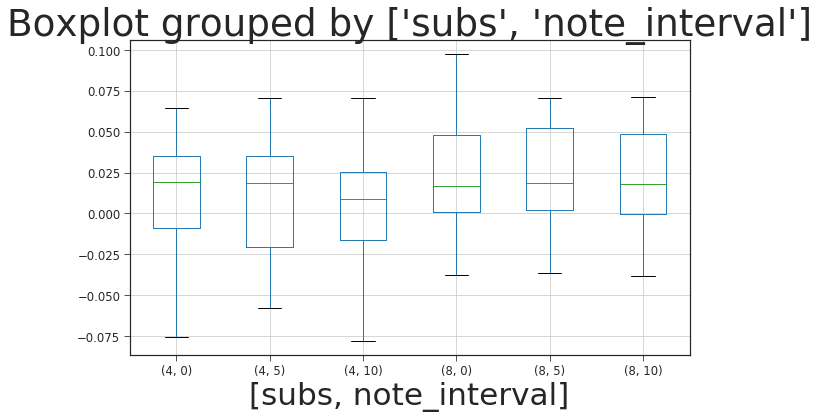

In [94]:
df2.boxplot(column= 'slope', by = ['subs','note_interval'],fontsize=12)
title("");

In [135]:
from scipy.stats import f_oneway,kruskal

gby = df2.slope.groupby(['subs','note_interval'])
para_anova = []
for k,v in gby.indices.items():
    para_anova.append( df2.slope.iloc[v].values )

f_oneway(*para_anova),kruskal(*para_anova)

(F_onewayResult(statistic=1.6282263924929357, pvalue=0.15560214367578082),
 KruskalResult(statistic=5.3011436794667475, pvalue=0.38024394140518752))

In [101]:
# x_reg = linspace(-1,1,30)
# seed(124)
# y_reg = randn(30)
# slope, intercept, r_value, p_value, std_err = linregress(x_reg, y_reg)
# plot(x_reg,y_reg,'o')
# plot(x_reg,slope*x_reg+intercept,'r')
# slope, intercept, r_value**2, p_value, std_err


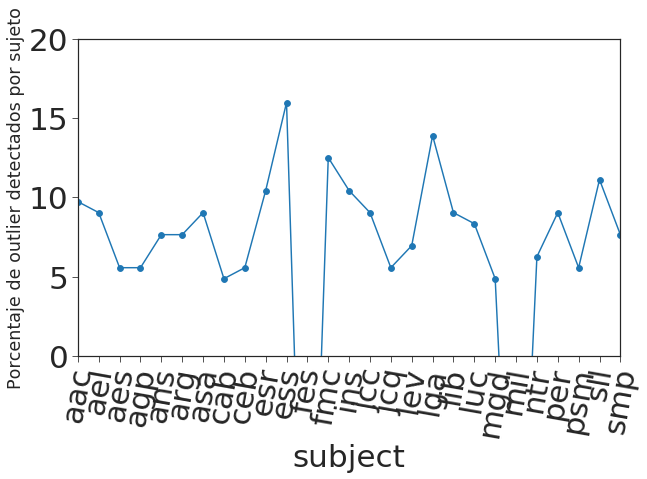

In [8]:
serie = 100-df2.groupby(['subject'])['n_inlier'].sum()/(24*6)*100
serie.plot(style='o-')
gca().set_xticks(arange(len(serie.index)))
gca().set_xticklabels(serie.index,rotation=80);
ylabel('Porcentaje de outlier detectados por sujeto',fontsize=18)
ylim(0,20);

In [97]:
def SUBJ_OUTLIER(l):
    x = vstack(l.values)
    
    mask = ones(x.shape[0],dtype=bool)
    for i in range(x.shape[1]):
        mask = (mask) & ( mask_outliers(x[:,i],2.0) )
    n = sum(mask)
    
    return pd.Series({'sub_mask':mask})

subj_mask = vstack(df2.u.unstack().unstack().apply(SUBJ_OUTLIER).T.sub_mask).prod(0)
subj_mask = subj_mask * vstack(df2.s.unstack().unstack().apply(SUBJ_OUTLIER).T.sub_mask).prod(0)
subj_mask = subj_mask.astype(bool)
# df2.index.levels[0], subj_mask
subj_in = list(df2.index.levels[0][subj_mask])
df2_ = df2.loc[subj_in]
subj_out = df2.index.levels[0][~subj_mask]
n_subjects = len(subj_in)

In [98]:
subj_out

Index(['ael', 'ceb', 'fmc', 'ins', 'jcc'], dtype='object', name='subject')

In [104]:
def MU_Y_SD(l):
    y = vstack(l.values)  
    s = std(y,0)
    u = mean(y,0)    
    nsteps = y.shape[1]

    x_reg = ones(y.shape)*arange(1,nsteps+1)*2.4/nsteps
#     x_reg = ones(y_mask.shape)*u
    y_reg = y
    x_reg = x_reg.flatten()
    y_reg = y_reg.flatten()-x_reg
    
    slope, intercept, r_value, p_value, std_err = linregress(x_reg, y_reg)    
    return pd.Series({'u':u,'s':s, 'slope': slope, 
                      'intercept': intercept, 'r2': r_value**2,
                     'p_value':p_value, 'std_err': std_err})

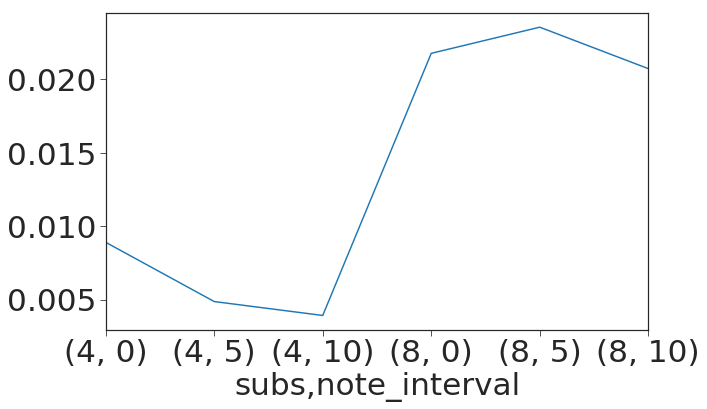

In [108]:
df3 = df2_.u.unstack().unstack().apply(MU_Y_SD).T
df3 = df3.swaplevel(i=0,j=1).sort_index()
df3.slope.plot()

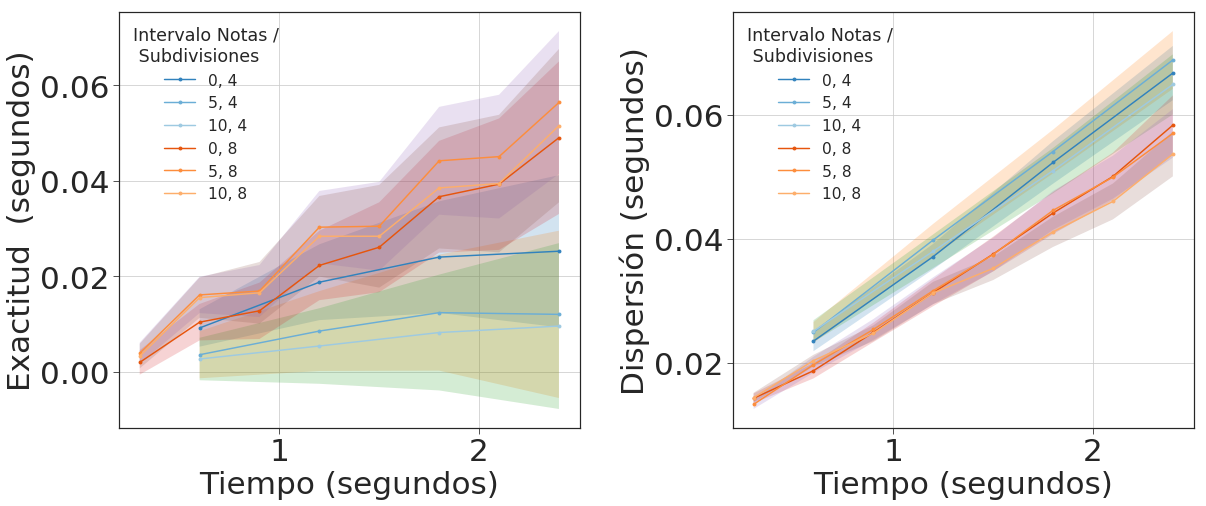

In [105]:
figure(figsize=(18,8))

#Exactitud
df3 = df2_.u.unstack().unstack().apply(MU_Y_SD).T
df3 = df3.swaplevel(i=0,j=1).sort_index()

subplot(1,2,1)
for (i,n),r in df3.iterrows():
    t = arange(1,i+1)*2.4/(i)
    y = r.u-t
    
    cix = ((i/4-1)*4+n/5)/20
   
    err = r.s/sqrt(n_subjects)
    plot(t,y,'.-',label='{}, {}'.format(n,i),color = cm.tab20c(cix))

    fill_between(t,y-err,y+err,alpha=0.2)    

legend(loc='best').set_title('Intervalo Notas /\n Subdivisiones',prop={'size':18});
xlabel('Tiempo (segundos)')
ylabel('Exactitud  (segundos)')
grid()
    
#Precisión
df3 = df2_.s.unstack().unstack().apply(MU_Y_SD).T
df3 = df3.swaplevel(i=0,j=1).sort_index()

subplot(1,2,2)
for  (i,n),r in df3.iterrows():
    t = arange(1,i+1)*2.4/(i)
    y = r.u
    err = r.s/sqrt(n_subjects)
    
    cix = ((i/4-1)*4+n/5)/20
    
    plot(t,y,'.-',label = '{}, {}'.format(n,i),color = cm.tab20c(cix) )
    
    fill_between(t,y-err,y+err,alpha=0.2)
    
legend(loc='best').set_title('Intervalo Notas /\n Subdivisiones',prop={'size':18});
xlabel('Tiempo (segundos)');
ylabel('Dispersión (segundos)');
grid()
tight_layout();

In [13]:
groups = df2.index.labels[1]*3+df2.index.labels[2]
data = df2.ls.values.astype(float64)
tuk = pairwise_tukeyhsd(data, groups)
tuk.summary()

group1,group2,meandiff,lower,upper,reject
0,1,0.0041,-0.0173,0.0255,False
0,2,0.0029,-0.0185,0.0243,False
0,3,-0.0118,-0.0332,0.0096,False
0,4,-0.0055,-0.0269,0.0158,False
0,5,-0.0095,-0.0309,0.0119,False
1,2,-0.0012,-0.0226,0.0202,False
1,3,-0.0159,-0.0373,0.0055,False
1,4,-0.0097,-0.031,0.0117,False
1,5,-0.0136,-0.035,0.0078,False
2,3,-0.0147,-0.0361,0.0067,False


In [14]:
# df_aux = pd.DataFrame()
# df_aux['datos'] = data
# df_aux['groups'] = groups
# df_aux.datos.hist(by=groups,figsize=(10,12),bins=6);

In [15]:
groups = df2.index.labels[1]*3+df2.index.labels[2]
data = df2.lu.values.astype(float64)-2.4

In [16]:
tuk = pairwise_tukeyhsd(data, groups)
tuk.summary()

group1,group2,meandiff,lower,upper,reject
0,1,-0.0163,-0.0769,0.0443,False
0,2,-0.0238,-0.0845,0.0368,False
0,3,0.0205,-0.0401,0.0812,False
0,4,0.0172,-0.0435,0.0778,False
0,5,0.0181,-0.0426,0.0787,False
1,2,-0.0075,-0.0682,0.0531,False
1,3,0.0368,-0.0238,0.0975,False
1,4,0.0335,-0.0272,0.0941,False
1,5,0.0344,-0.0263,0.095,False
2,3,0.0444,-0.0163,0.105,False


In [17]:
# tuk.plot_simultaneous()

/usr/local/lib/python3.4/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/usr/local/lib/python3.4/dist-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


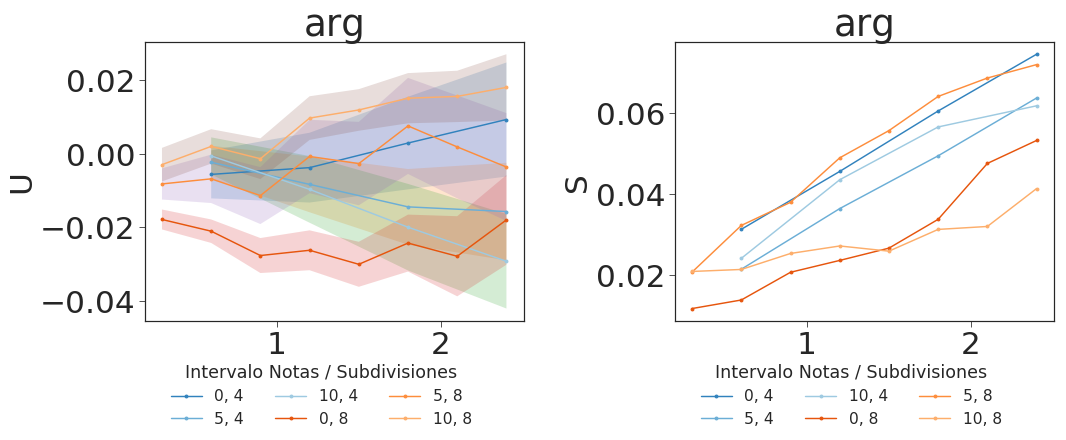

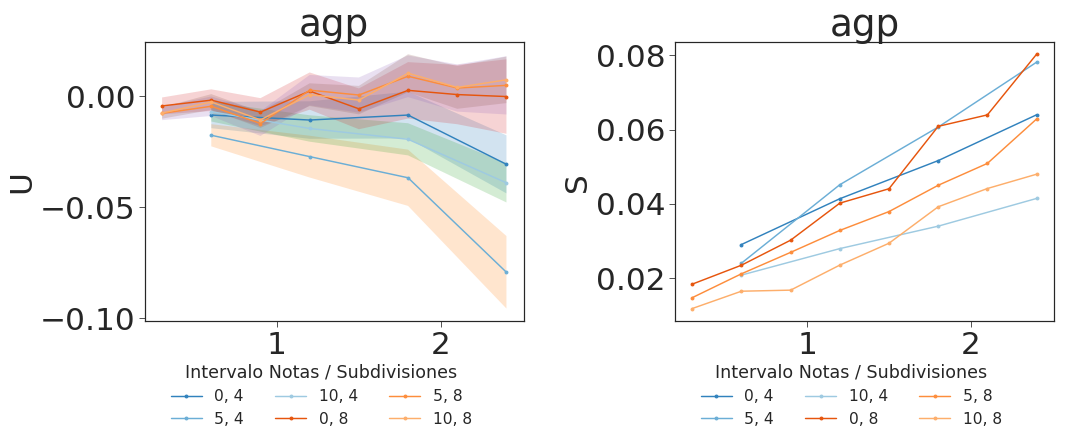

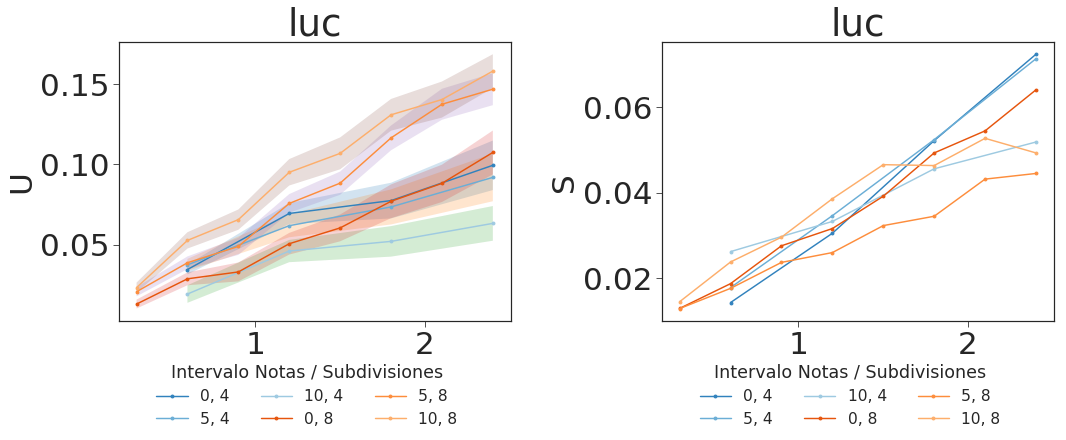

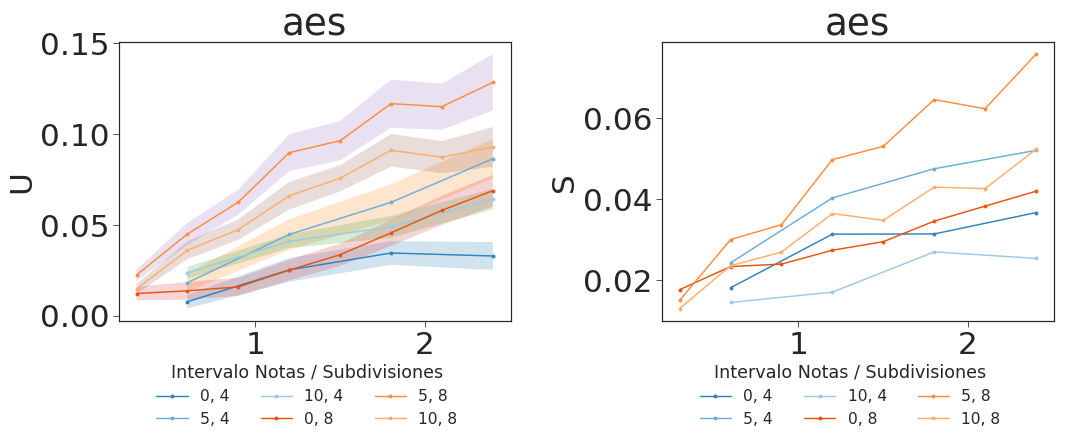

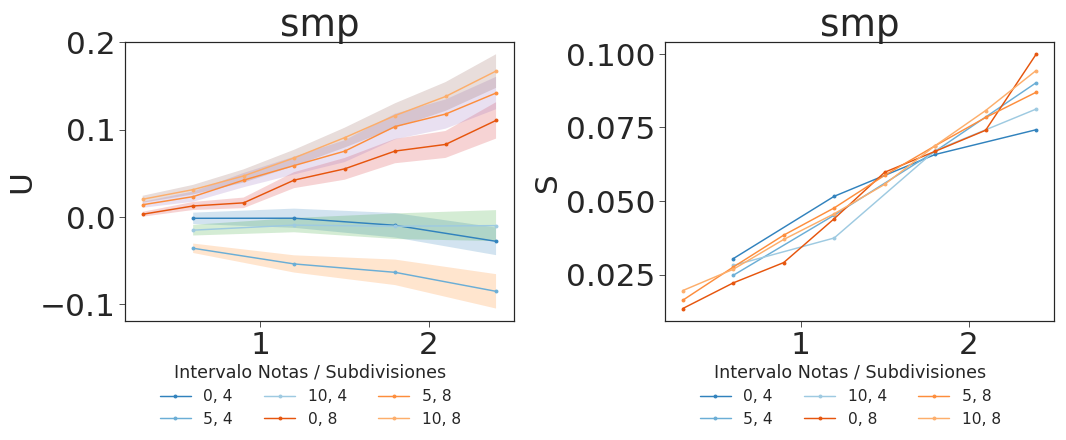

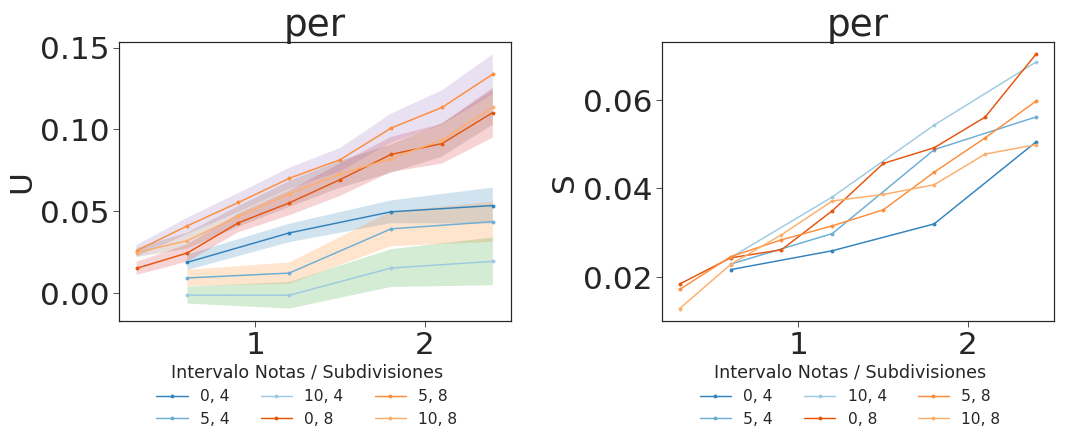

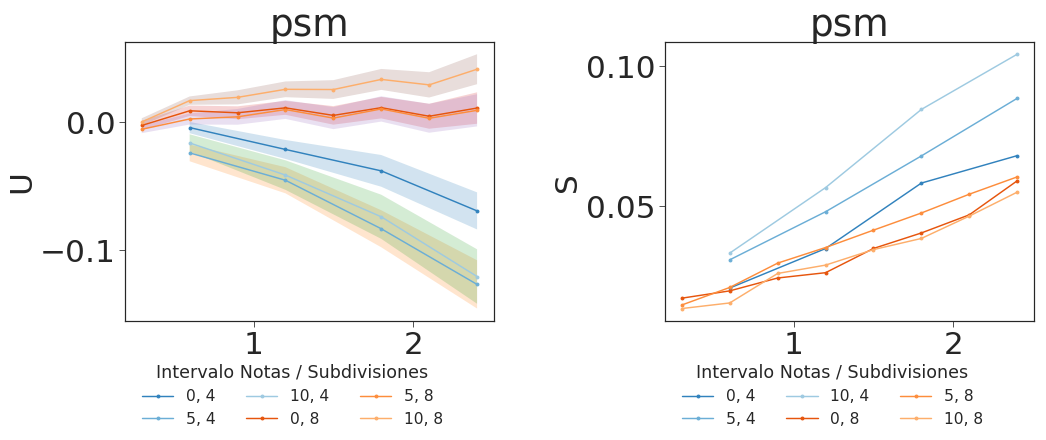

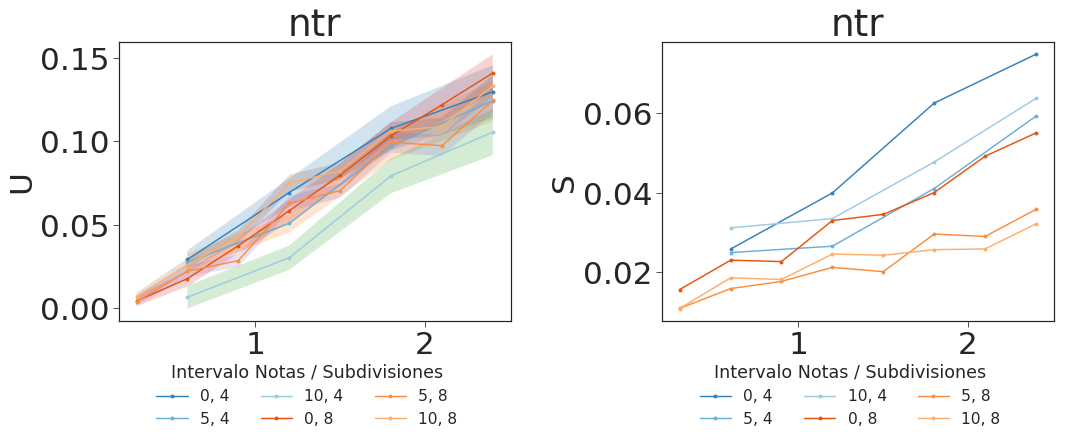

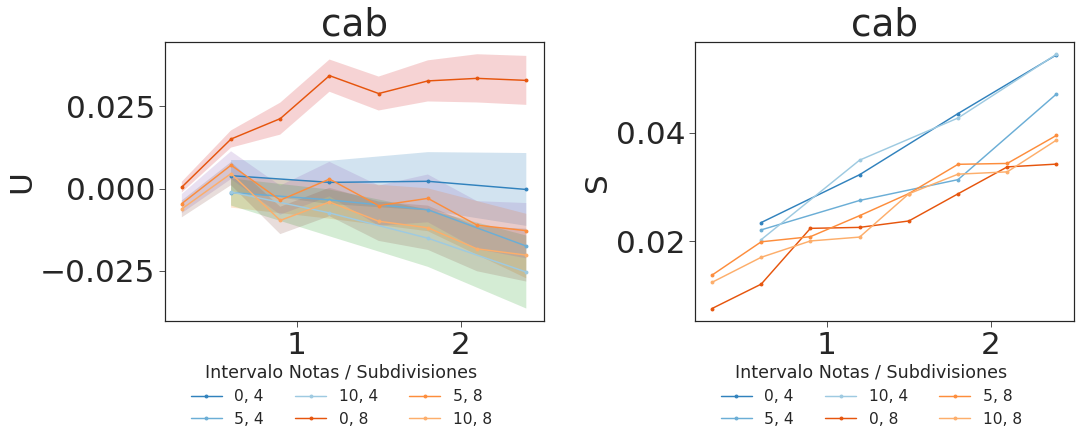

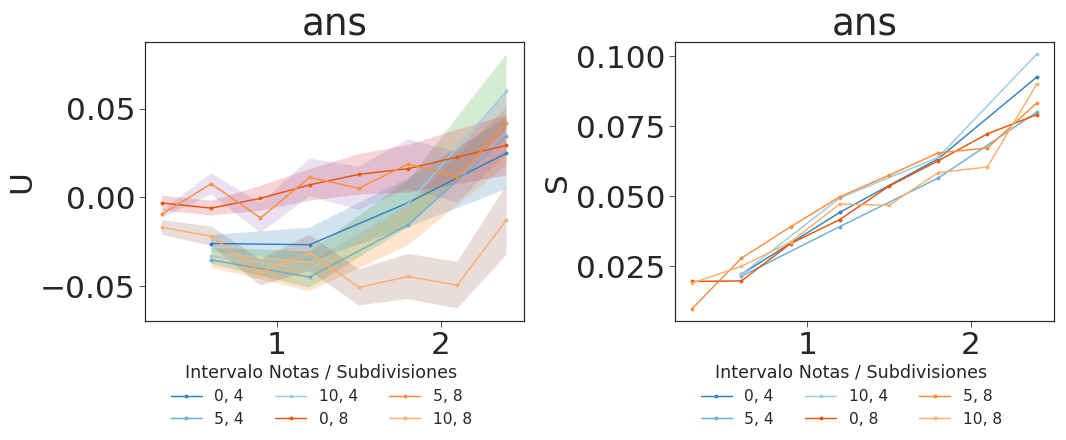

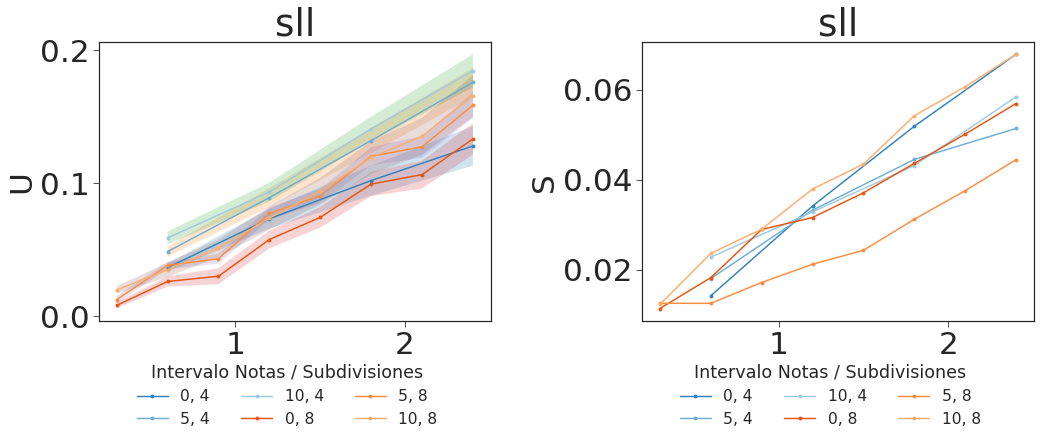

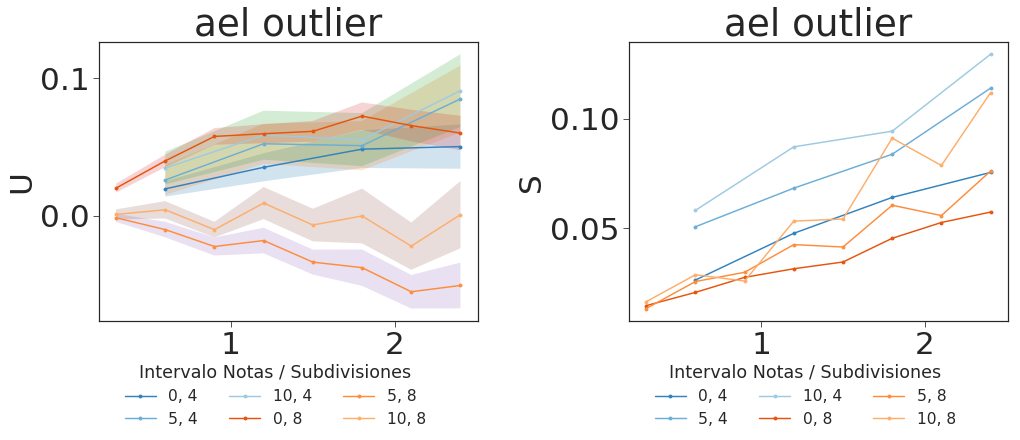

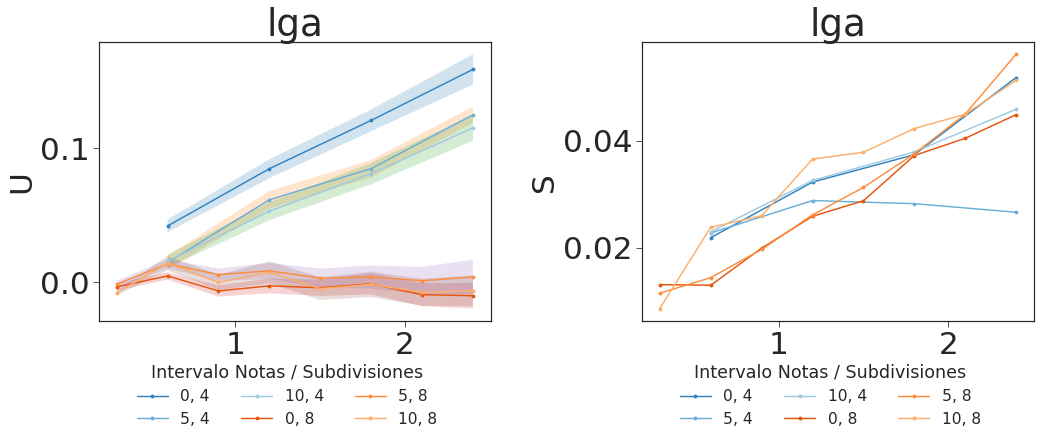

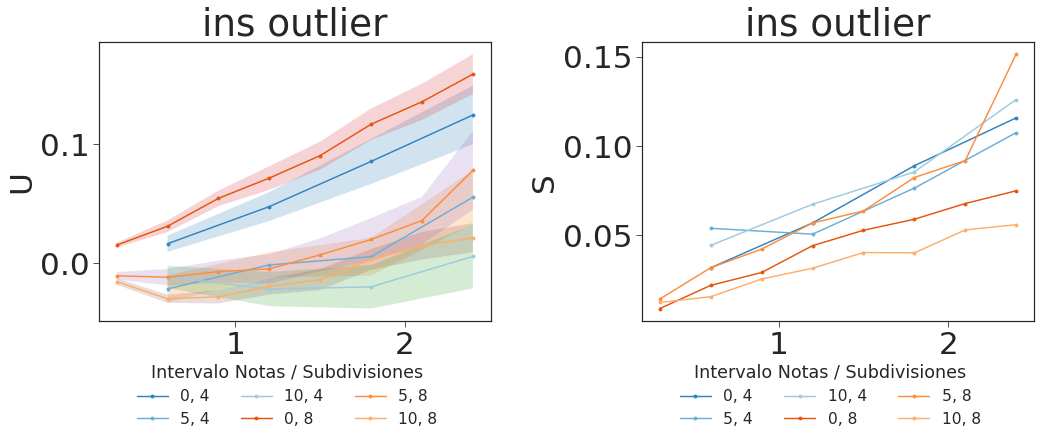

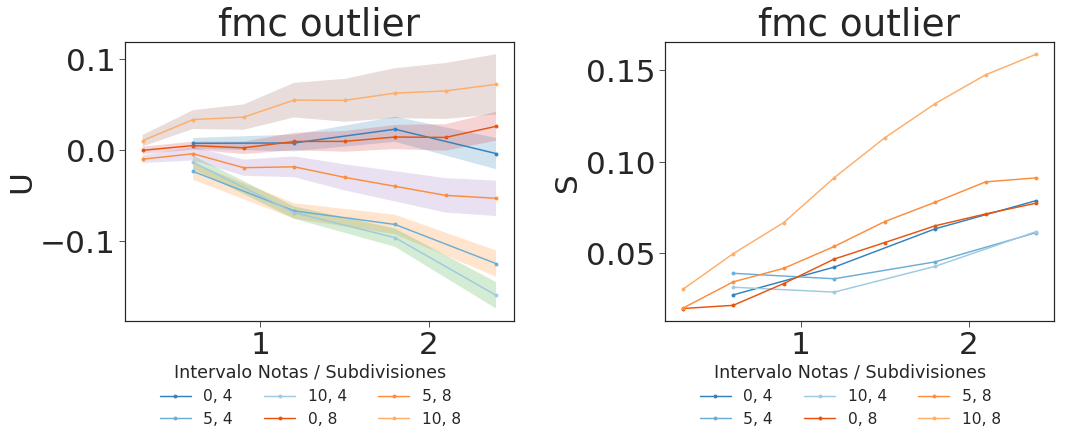

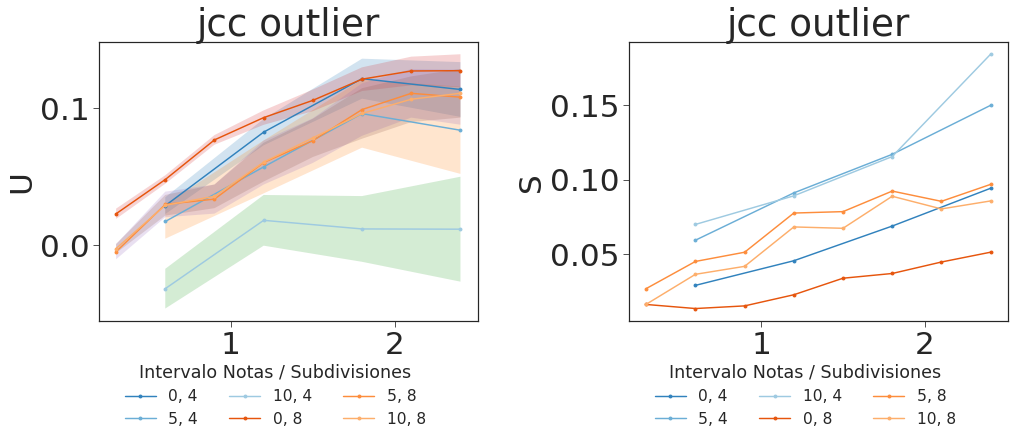

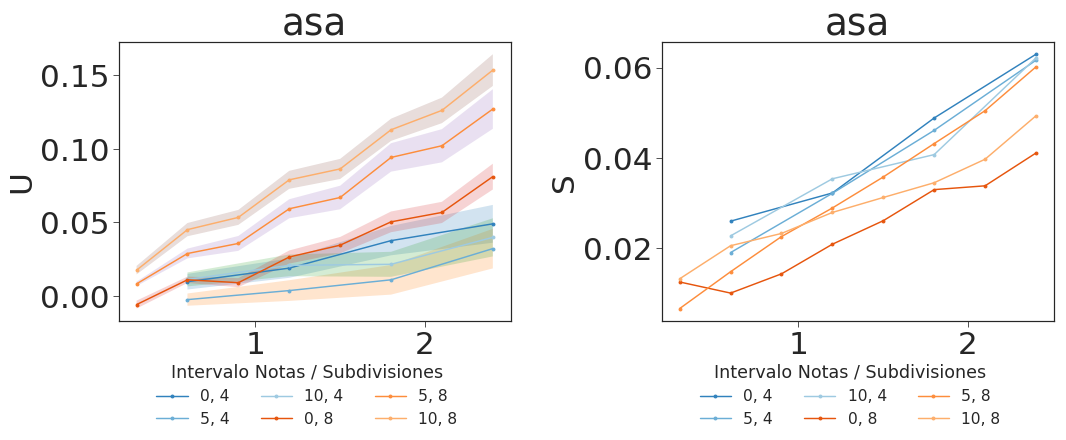

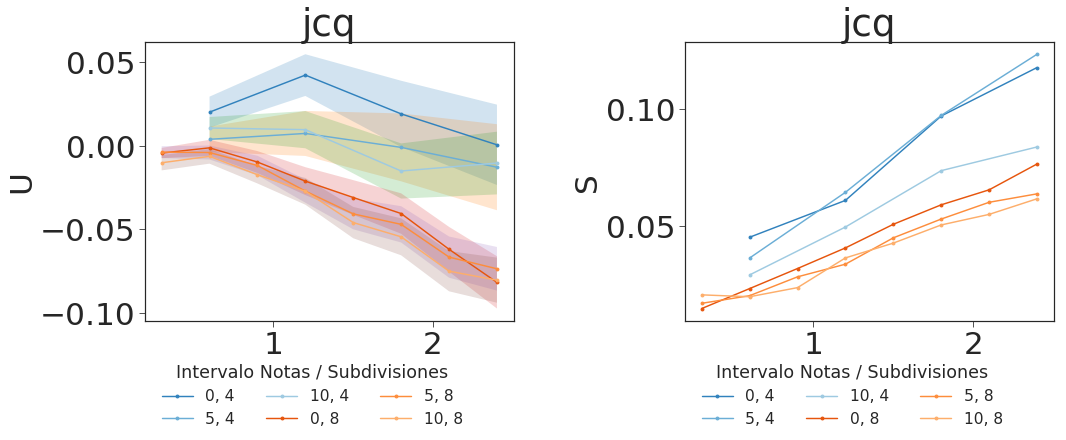

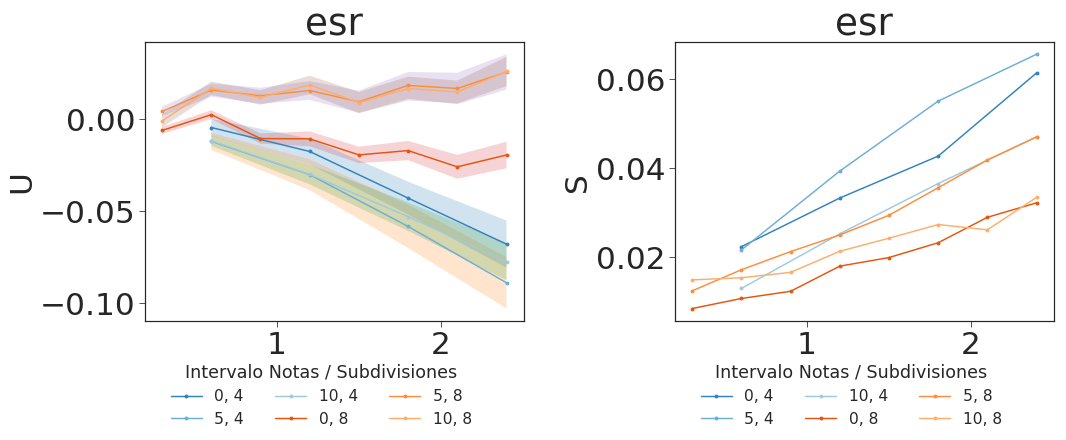

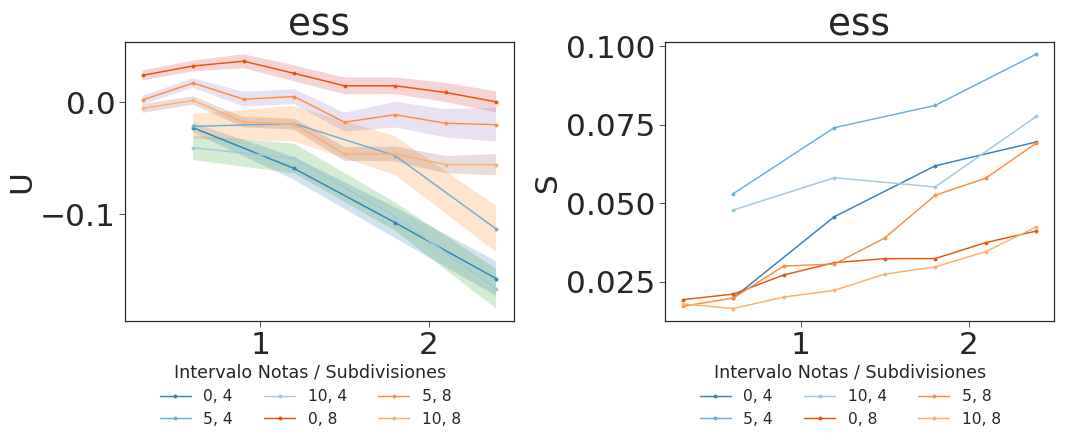

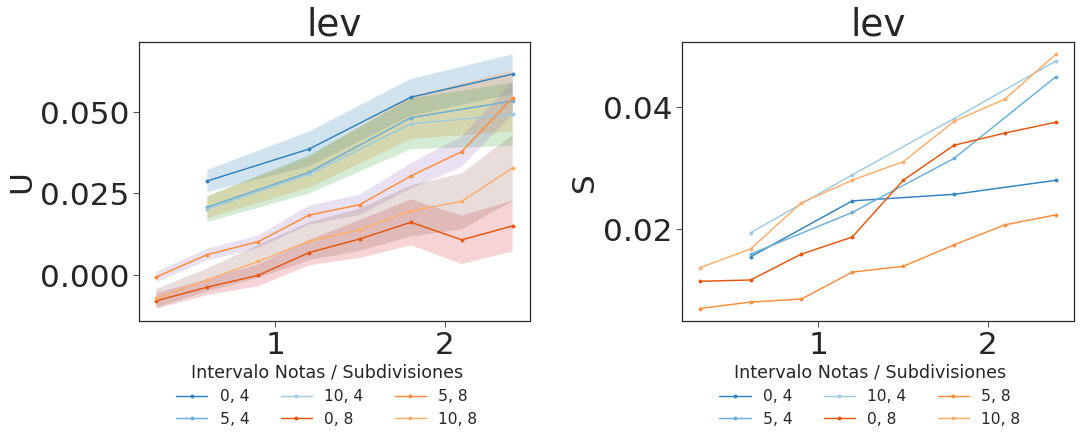

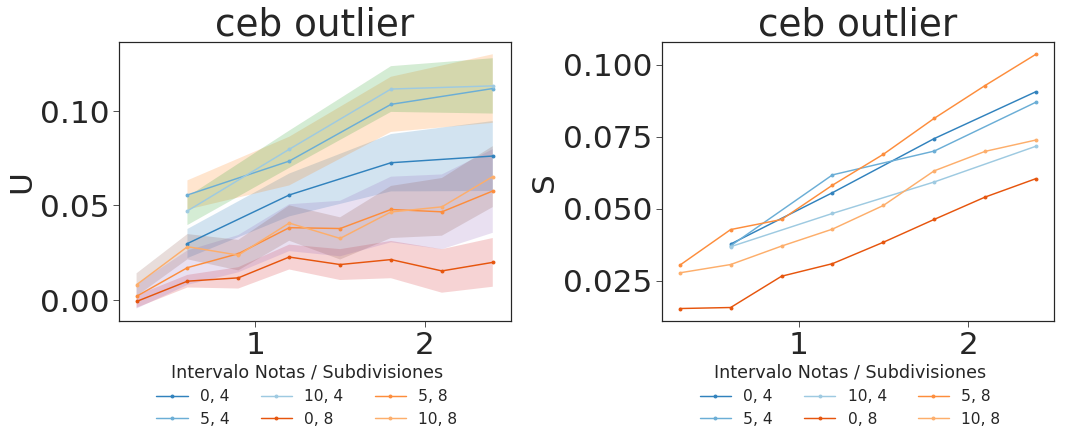

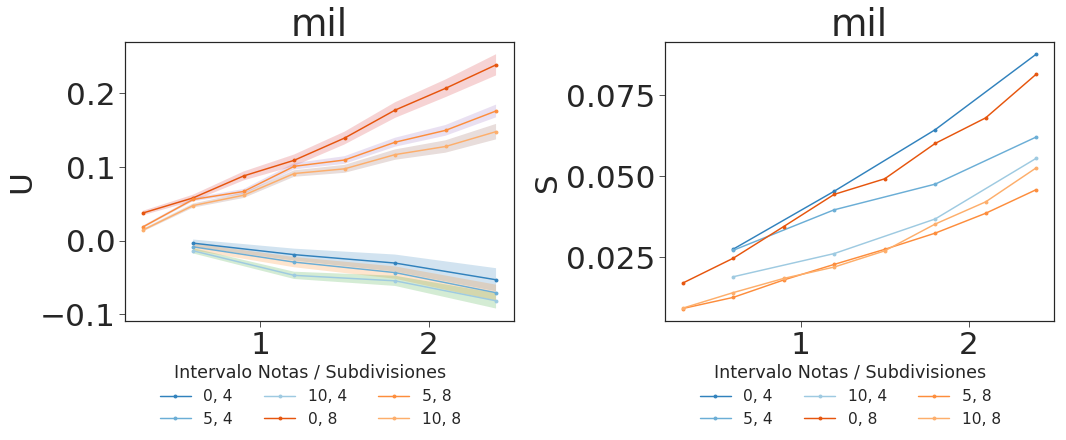

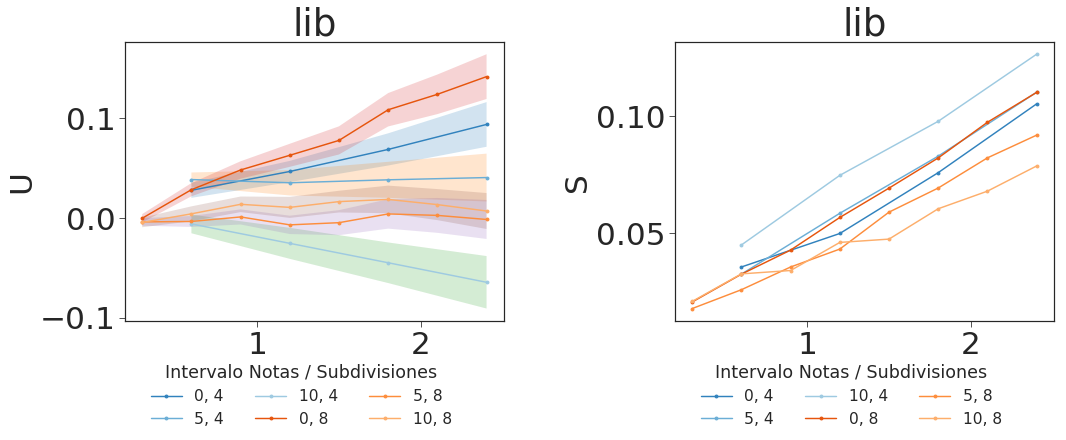

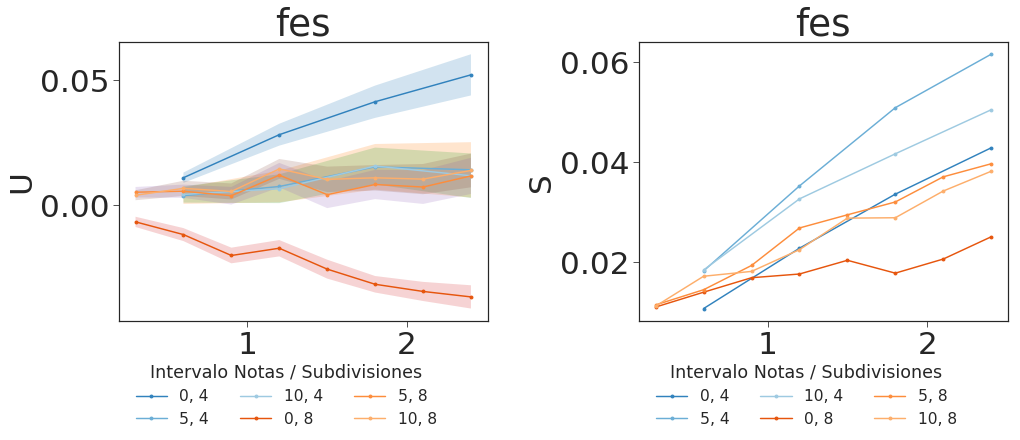

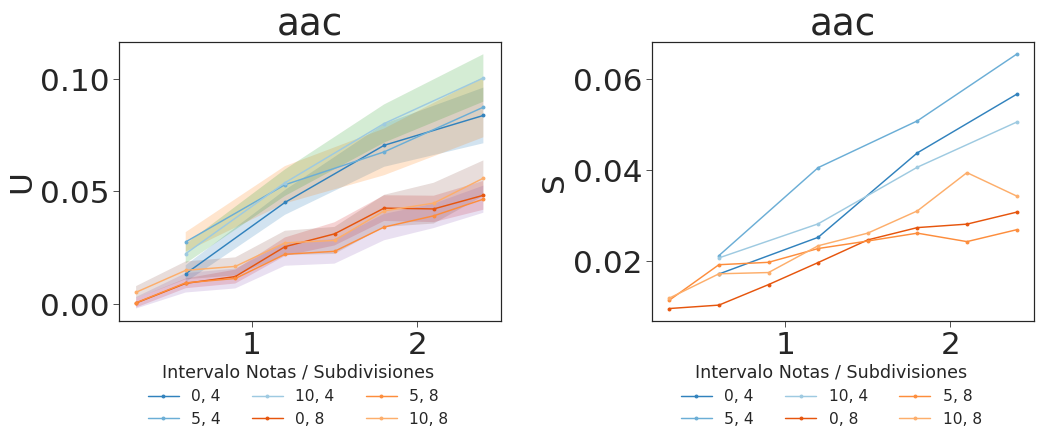

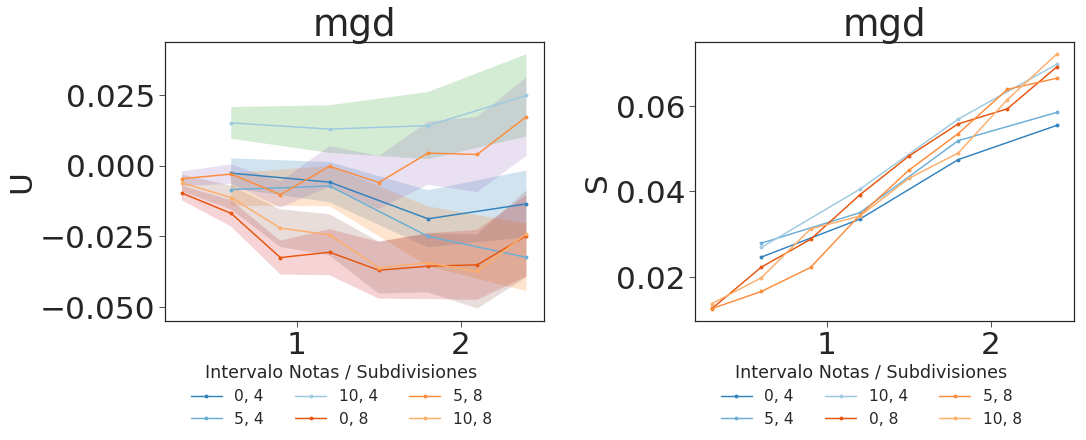

In [18]:
for k,subj in enumerate(df.subject.unique()):
    figure(k,figsize=(16,6))
    
    df3 = df2.loc[subj]
    for  (i,n),r in df3.iterrows():
        t = arange(1,i+1)*2.4/(i)
        y = r.u-t
        err = r.s/sqrt(r.n_inlier)

        cix = ((i/4-1)*4+n/5)/20

        subplot(1,2,1)
        plot(t,y,'.-',label = '{}, {}'.format(n,i),color = cm.tab20c(cix) )               

        fill_between(t,y-err,y+err,alpha=0.2)
        
        subplot(1,2,2)
        plot(t,r.s,'.-',label = '{}, {}'.format(n,i),color = cm.tab20c(cix) )
        
#         fill_between(t,r.s-err,r.s+err,alpha=0.2)
        
        ylabel('Dispersión (segundos)');

    subplot(1,2,1)
    legend(bbox_to_anchor=(0.9, -0.1),ncol=3).set_title('Intervalo Notas / Subdivisiones',prop={'size':18});
    
    title(subj)    
    if subj in subj_out:    
        title(subj+' outlier')
        
    ylabel('U')

    subplot(1,2,2)
    legend(bbox_to_anchor=(0.9, -0.1),ncol=3).set_title('Intervalo Notas / Subdivisiones',prop={'size':18});
    
    title(subj)    
    if subj in subj_out:    
        title(subj+' outlier')
    
    ylabel('S');
    tight_layout()

In [21]:
# for k,subj in enumerate(df.subject.unique()):
#     figure(k,figsize=(16,6))
    
#     df3 = df2.loc[subj]
#     for  (i,n),r in df3.iterrows():
#         t = arange(1,i+1)*2.4/(i)
#         y = r.u-t
#         err = r.s/sqrt(r.n_inlier)

In [20]:
df3

ls       lu n_inlier  \
subs note_interval                                
4    0               0.055456  2.38642       22   
     5              0.0585042  2.36749       24   
     10             0.0697694  2.42483       23   
8    0              0.0691433  2.37516       23   
     5              0.0665198  2.41732       23   
     10             0.0721516  2.37585       22   

                                                                    s  \
subs note_interval                                                      
4    0              [0.02459213205, 0.0334899515122, 0.04744053210...   
     5              [0.0278600386846, 0.0349983255809, 0.051889989...   
     10             [0.0268485995033, 0.0404906020898, 0.056946057...   
8    0              [0.0125566459908, 0.0222425136956, 0.028749792...   
     5              [0.0125364881263, 0.0165302078421, 0.022171744...   
     10             [0.0137156887481, 0.0197380498914, 0.031190711...   

                                                                    u  
subs note_interval                                                     
4    0              [0.597300556586, 1.19411358483, 1.78114306329,...  
     5              [0.591480536659, 1.19275132275, 1.77492913832,...  
     10             [0.615089224095, 1.21289362122, 1.81413289954,...  
8    0              [0.290238588189, 0.583044464162, 0.86741792369...  
     5              [0.295333727694, 0.596962437149, 0.88972789115...  
     10             [0.293843537415, 0.588667285096, 0.87783446712...

In [431]:
# df3 = df2.s.unstack().apply(MU_Y_SD).T
# df4 =  df2.u.unstack().apply(MU_Y_SD).T

# for i,r in df3.iterrows():
#     t = arange(1,i+1)*2.4/(i)
#     y = r.u
#     err = r.s/sqrt(n_subjects)
#     plot(t,y,'.-',label=i)
#     fill_between(t,y-err,y+err,alpha=0.2)
    
# legend(title='Subdivisiones');
# xlabel('Tiempo (segundos)');
# ylabel('Dispersión (segundos)');
# grid()
# tight_layout();

In [24]:
df2_[['u','s']].unstack().unstack().apply(MU_Y_SD).T

s  \
  note_interval subs                                                      
u 0             4     [0.0183564096944, 0.0372009520459, 0.054754950...   
                8     [0.0120518590129, 0.0179116845809, 0.027641202...   
  5             4     [0.0230970022891, 0.0391781265682, 0.056892204...   
                8     [0.0104047588144, 0.0178232370869, 0.025522371...   
  10            4     [0.0208134784059, 0.03707146614, 0.05681693661...   
                8     [0.0120616095993, 0.0197976881744, 0.030231831...   
s 0             4     [0.00764964211018, 0.00964018695826, 0.0160841...   
                8     [0.00367227174418, 0.00584838673749, 0.0073327...   
  5             4     [0.0078388896202, 0.0121997865114, 0.016517716...   
                8     [0.00348154342447, 0.00604954502067, 0.0078761...   
  10            4     [0.00827017667373, 0.0127239132516, 0.01709765...   
                8     [0.00367079099806, 0.00442531533822, 0.0059604...   

                                                                      u  
  note_interval subs                                                     
u 0             4     [0.609228466012, 1.2187990903, 1.82405192205, ...  
                8     [0.302022301527, 0.610439887324, 0.91281645865...  
  5             4     [0.603624596263, 1.20857749113, 1.81243042704,...  
                8     [0.30394779745, 0.616142943616, 0.916949393335...  
  10            4     [0.602729611854, 1.20544960864, 1.80826806325,...  
                8     [0.303340722384, 0.615571245435, 0.91657804396...  
s 0             4     [0.0235192159432, 0.0371510848068, 0.052323070...  
                8     [0.0142913542246, 0.018743679971, 0.0249240094...  
  5             4     [0.0249167850758, 0.0398263028843, 0.054087448...  
                8     [0.0133140447216, 0.01970958188, 0.02539451305...  
  10            4     [0.0251192974343, 0.0380149719526, 0.051004400...  
                8     [0.0143942660735, 0.0203694622566, 0.024783805...